# BIOMEDIN 260/RAD260: Problem Set 3 - Mammogram Project

## Spring 2020

## Name 1:

Kristen Anderson

## Name 2:

Ryan Crowley

## Introduction

Breast cancer has the highest incidence and second highest mortality rate for women in the US.

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Turning in a deep dream assignment using mammograms might be amusing, for example, but not so useful to patients. That being said, choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, at least in BMI 260."

Treat this as a mini-project. We highly encourage working with 1 other person, possibly someone in your main project team. 

In addition to the mammograms themselves, the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You dont need to use all of what is provided to you.

Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on those features using the algorithms presented to you in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any of the code we went over in class or use your own (custom code, sklearn, keras, Tensorflow etc.). If you dont want to place helper functions and classes into this notebook, place them in a `.py` file in the same folder called `helperfunctions.py` and import them into this notebook.

## Data

The data is here:

https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM

## Grading and Submission

This assignment has 3 components: code, figures (outputs/analyses of your code), and a write-up detailing your mini-project. You will be graded on these categories.

If you're OK with Python or R, please place all three parts into this notebook/.Rmd file that we have provided where indicated. We have written template sections for you to follow for simplicity/completeness. When you're done, save as a `.pdf` (please knit to `.pdf` if you are using `.Rmd`, or knit to `.html` and use a browser's "Print" function to convert to `.pdf`).

If you don't like Python OR R, we will allow you to use a different language, but please turn your assignment in with: 1) a folder with all your code, 2) a folder with all your figures, and 3) a `.tex`/`.doc`/`.pdf` file with a write-up.

## Differentiating between Malignant and Benign Masses in Mammograms using Transfer Learning

**1. Describe what you are doing and why it matters to patients using at least one citation.**

We will use the VGG-16 CNN to diagnose benign and malignant tumors in mammograms. In doing so, we could help doctors diagnose cancer at earlier stages through discovering malignant tumors that may otherwise be missed. CNNs have been shown to classify mammogram images with an overall sensitivity of 96% and a 0.99 AUC [1]. In contrast, doctors acurately diagnose breast cancer through mammography in about 78% of their patients, with diagnostic accuracy rising to about 83% when female patients are older than 50 [2].

The difference between these scores suggests both a significant need for technological aid as well as the CNN's capacity to effectively improve diagnosis. The chance that a woman will die from breast cancer is about 1 in 38, so reducing this risk could save many women's lives [3]. Early diagnosis gives women the opportunity to receive proper medical care when fighting cancer.

1. https://pubmed.ncbi.nlm.nih.gov/31838610/
2. https://www.uchealth.org/today/how-accurate-are-mammograms/
3. https://www.cancer.org/cancer/breast-cancer/about/how-common-is-breast-cancer.html

**2. Describe the relevant statistics of the data. How were the images taken? How were they labeled? What is the class balance and majority classifier accuracy? How will you divide the data into testing, training and validation sets?**

The images are taken using low-dose X-ray mammography as the imgaging technique. These images were collected from a variety of sources including Massachusetts General Hopsital and Washington University of St. Louis School of Medicine. The images are labeled with diverse information including ROIs for calcifications and masses as well as BI-RADS information about the mass shape, mass margin, breast density, and other data. There also exists other metadata that include the patient age, date of study, scanner used to digitize, and resolution of the image along other data. Cases with abnormalities also contain extra information including the type of abnormality. We will be focusing upon the masses. There is a training set of 653 benign abnormalities and 621 malignant abnormalities. There also exists a testing set with 189 benign abnormalities and 156 malignant abnormalities. As such, the majority classifer accuracy on the test set is .5478. We will keep the groups sorted as given and will not perform any hyperparameter tuning so a validation set will not be neccessary.

**3. Describe your data pipeline (how is the data scrubbed, normalized, stored, and fed to the model for training?).**

The data pipeline that we developed first used the csv files to link individual patient ID's with the associated diagnosis of whether the mass was benign or malignant. We then looped through all of the individual ROI images in the "data_fixed_crop_w_mask" folder to assign them into either the training malignant folder or the training benign folder. We also cut the images down in size to 224 x 224 pixels as this is the required input for our version of VGG-16. We chose to cut the images down by taking the center 224 x 224 pixels and cutting off the border around each image. We then performed the same data preprocessing with all of the individual ROI images in the "test" folder to assign them either to the test malignant folder or the test benign folder and cut them down in size as well to 224 x 224 pixels.

**4. Explain how the model you chose works alongside the code for it. Add at least one technical citation to give credit where credit is due.**

In [21]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import os
import skimage
import h5py
import csv
%matplotlib inline
import keras
import PIL
from PIL import Image
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
#Create a dictionary that links patient id to outcome
dictionary = {};
with open('mass_case_description_train_set-1.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        key = row[0]
  
        dictionary[key] = row[9]
with open('mass_case_description_test_set-1.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        key = row[0]
        dictionary[key] = row[9]

In [26]:
#Create the training data set
directory = "data_fixed_crop_w_mask"
for folder in os.listdir(directory):
    path = directory + "/" + folder;
    sum = 0
    for filename in os.listdir(path):
        sum += 1
        fullFilePath = directory + "/" + folder + "/" + filename;
        f = h5py.File(fullFilePath, "r")
        datasetNames = [n for n in f.keys()]
        a_group = f['data']
        second = a_group[:,:,1]
        finalImage = second[16:240,16:240]
        
        patient_ID =  "P_" + folder;
        if patient_ID in dictionary:
            for row in range(0,224):
                for col in range(0,224):
                    if finalImage[row,col] < .5:
                        finalImage[row,col] = 0
                    else:
                        finalImage[row,col] = 255
            im = Image.fromarray(finalImage)
            im = im.convert("L")

            if dictionary[patient_ID] == "MALIGNANT":
                im.save('trainSorted/malignant/'+patient_ID+'_'+str(sum)+'.png', 'png')
            else:
                im.save('trainSorted/benign/'+patient_ID+'_'+str(sum)+'.png', 'png')

In [27]:
#Create the testing dataset
directory = "test"
for folder in os.listdir(directory):
    path = directory + "/" + folder;
    if path != 'test/.DS_Store': 
        sum = 0
        for filename in os.listdir(path):
            sum += 1
            fullFilePath = directory + "/" + folder + "/" + filename;
            f = h5py.File(fullFilePath, "r")
            datasetNames = [n for n in f.keys()]
            a_group = f['data']
            second = a_group[:,:,1]
            finalImage = second[16:240,16:240]

            patient_ID =  "P_" + folder;
            if patient_ID in dictionary:
                for row in range(0,224):
                    for col in range(0,224):
                        if finalImage[row,col] < .5:
                            finalImage[row,col] = 0
                        else:
                            finalImage[row,col] = 255
                im = Image.fromarray(finalImage)
                im = im.convert("L")

                if dictionary[patient_ID] == "MALIGNANT":
                    im.save('testSorted/malignant/'+patient_ID+'_'+str(sum)+'.png', 'png')
                else:
                    im.save('testSorted/benign/'+patient_ID+'_'+str(sum)+'.png', 'png')

In [28]:
#Load the data so that it can be used in the model
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="/Users/ryancrowley/Desktop/BMI 260/trainSorted/",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="/Users/ryancrowley/Desktop/BMI 260/testSorted/", target_size=(224,224))

Found 1274 images belonging to 2 classes.
Found 345 images belonging to 2 classes.


In [29]:
#Edit the model so that it works for this application
vggmodel = VGG16(weights='imagenet', include_top=True)
for layers in (vggmodel.layers)[:19]:
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(input = vggmodel.input, output = predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
model_final.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

/Users/ryancrowley/opt/anaconda3/envs/bmi2602/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [30]:
#Run the training and validation of the model
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')
model_final.fit_generator(generator= traindata, steps_per_epoch= 2, epochs= 100, validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])
model_final.save_weights("vgg16_1.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2/2 [==============================] - 58s 29s/step - loss: 0.9766 - accuracy: 0.5469 - val_loss: 1.1089 - val_accuracy: 0.3750
Epoch 2/100


/Users/ryancrowley/opt/anaconda3/envs/bmi2602/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/Users/ryancrowley/opt/anaconda3/envs/bmi2602/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2/2 [==============================] - 46s 23s/step - loss: 1.1332 - accuracy: 0.5156 - val_loss: 0.6396 - val_accuracy: 0.5625
Epoch 3/100
2/2 [==============================] - 45s 23s/step - loss: 1.0413 - accuracy: 0.5312 - val_loss: 0.9555 - val_accuracy: 0.6250
Epoch 4/100
2/2 [==============================] - 48s 24s/step - loss: 1.0534 - accuracy: 0.5000 - val_loss: 1.0931 - val_accuracy: 0.4375
Epoch 5/100
2/2 [==============================] - 48s 24s/step - loss: 1.1376 - accuracy: 0.5156 - val_loss: 0.8782 - val_accuracy: 0.6250
Epoch 6/100
2/2 [==============================] - 57s 29s/step - loss: 1.0228 - accuracy: 0.5625 - val_loss: 1.3707 - val_accuracy: 0.4688
Epoch 7/100
2/2 [==============================] - 52s 26s/step - loss: 1.1867 - accuracy: 0.5156 - val_loss: 0.7215 - val_accuracy: 0.5000
Epoch 8/100
2/2 [==============================] - 54s 27s/step - loss: 0.9830 - accuracy: 0.4531 - val_loss: 1.1456 - val_accuracy: 0.3125
Epoch 9/100
2/2 [===============

After the data preprocessing steps, we then loaded the data into the correct format by using ImageDataGenerator. From here, we then imported the VGG-16 model that was pretrained on the ImageNet dataset. We then altered the structure of the network such that it only outputs malignant or benign instead of the 1000 different categories it would output in the past. We also altered the network such that the first 19 layers were frozen as part of the transfer learning approach. This approach is overall similar to a transfer learning approach using previously to differentiate between COVID-19 and viral pneumonia with a great deal of success [1]. 

1.https://arxiv.org/abs/2003.13145

**5. There are many ways to do training. Take us through how you do it (e.g. "We used early stopping and stopped when validation loss increased twice in a row.").**

We used an early stopping criteria where we would stop if the validation accuracy did not change over the course of two consecutive epochs. Additionally, we trained using a total of 100 epochs with 2 steps per epoch. Our learning rate was eta = 0.0001, and we used Stochastic Gradient Descent with momentum = .9

**6. Make a figure displaying your results.**

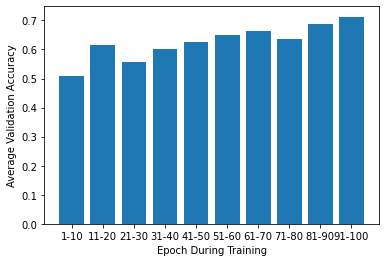

In [32]:
height = [.50939,.61637,.55651,.60192,.62513,.65012,.66319,.63638,.68764,.71263]
bars = ('1-10', '11-20', '21-30', '31-40', '41-50','51-60','61-70','71-80','81-90','91-100')
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)

plt.xlabel("Epoch During Training")

plt.ylabel("Average Validation Accuracy")
 
# Show graphic
plt.show()


Here, we asssessed the average validation accuracy over 10 different intervals during the training process. Overall, we found that the validation accuracy appeared to increase over the course of the training indicating that the model was working as intended. Of note, the model outperforms the majority classifier accuracy of .5478

**7. Discuss pros and cons of your method and what you might have done differently now that you've tried or would try if you had more time.**

Of note, this method achieved a moderate level of success with our final 10 iterations of the model averaging a validation accuracy of .71263  Our model appeared to show some success in differentiating between benign and malignant tumors. This is likely largely due to the fact that CNNs are powerful for image analysis and transfer learning can be an effective method for quickly and efficiently training a model. Some possible limitations of our approach included our relatively small amount of data, the fact that no textural features could be calculated due to the fact that our input images were segmentations, and a relatively short training period. Additionally, accuracy appeared to fluctuate significantly indicating that the model was quite variable. Finally, the model that we developed may not easily fit into clinical workflows due to the need to determine the boundaries of the ROI. If we had had more time and more computational power, we could have tried to use more images to train the dataset and trained the model over the course of more epochs. Of course, there would then exist the possibility of overfitting so if we chose to train for more epochs we would also include additional methods to regularize the model. Overall, our approach shows some promise but also leaves significant room for improvement.

**You will not be graded on the performance of your model. You'll only be graded on the scientific soundness of your claims, methodology, evaluation (i.e. fair but insightful statistics), and discussion of the strengths and shortcomings of what you tried. Feel free to reuse some of the code you are/will be using for your projects. The write-up doesn't need to be long (~1 page will suffice), but please cite at least one clinical paper and one technical paper (1 each in questions 1 and 4 at least, and more if needed).**